In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
%matplotlib inline

In [2]:
def get_df(path,
           col_list=None):
    """
    create pandas dataframe from csv
    :param: path - the file path to the csv
    :param:  col_list - select subset of columns to make dataframe
    """
    df = pd.read_csv(os.path.abspath(path))
    if col_list is not None:
        df = df[col_list]
    df.dropna(inplace=True)
    return df

In [3]:
def convert_price(df):
    """
    function removes dollar sign from price string and then converts the price to a np.float32
    :param: price_usd: string the begins with $, followed by the dollar amount with a possible comma, then a period, then two digits as seconds
    """
    convert_usd_to_float = lambda price_usd: np.float32(price_usd.replace("$", "").replace(",", ""))
    df["price"] = df["price"].apply(lambda price_usd: convert_usd_to_float(price_usd))

In [4]:
def get_listing_series(df, listing_id, num_periods=13):
    """
    function returns mean price per year-month for selected listing_id
    :param: df: pandas DataFrame containing "listing_id", "date", "price" columns.
                The columns are assumed to have to following data types
                "listing_id": int
                "date": datetime
                "price": float
    :param: listing_id: listing id int provided in calendar.csv
    :param: len_series: number of periods (months) represented in grouped series 
    """
    # get listing of all dates and prices per unique listing
    listing_df = df.loc[df.listing_id == listing_id].drop(columns="listing_id")

    # replace index with date and delete date column
    listing_df = listing_df.set_index(listing_df.date).drop(columns="date")

    # convert from pandas df to pandas series
    listing_series = listing_df.squeeze()

    # make sure more than one value to examine
    if isinstance(listing_series, np.float64):
        return None
    
    # find mean price per year-month
    listing_series = listing_series.groupby(pd.Grouper(freq='M')).mean()

    # make sure data points for all months
    if len(listing_series) != num_periods:
        return None
    
    # interpolate missing values
    num_na = sum(listing_series.isna())
    
    if num_na:
        if num_na / num_periods <= 0.5:
            listing_series.interpolate(method='nearest', inplace=True)
        else:
            return None
    listing_series = listing_series.pct_change()
    listing_series.dropna(inplace=True)
    return listing_series

In [5]:
def get_listing_df(df):
    """
    create a dataframe that has average prices per listing over time
    """
    listing_dict = {}
    for listing_id in df.listing_id.unique():
        listing_series = get_listing_series(df, listing_id)
        if listing_series is not None:
            listing_dict[listing_id] = listing_series

    # Convert dict to df
    df1 = pd.DataFrame(listing_dict)
    # Transpose df
    return df1.T

In [6]:
def add_neighborhood_to_df(df1, df2):
    """
    joins 2 data frames
    """
    id_to_neghborhood = {row["id"]: row["neighbourhood_cleansed"] for _, row in df2.iterrows()}
    neighborhood_data = [id_to_neghborhood[listing_id] for listing_id in df1.index]
    neighborhoods = pd.Series(data=neighborhood_data, index=df1.index, name='neighborhoods')
    df1["neighborhoods"] = neighborhoods


def get_neighborhood_avg_price_rate(df_neighborhood):
    """
    
    """
    df_neighborhood_avg_price_rate = df_neighborhood.groupby("neighborhoods").mean().T
    return df_neighborhood_avg_price_rate

In [7]:
def plot_neghborhood_price_rates(df3, n_neighborhoods, top=True):
    """
    
    """
    city_average = df3.cumsum().mean(axis=1)
    if top:
        top_neighborhoods = df3.cumsum().loc[df3.index[-1]].squeeze().nlargest(n_neighborhoods).index
        df4 = df3[top_neighborhoods].cumsum()
        df4["City Average"] = city_average
        df4.plot.line()
        plt.show()
    else:
        bottom_neighborhoods = df3.cumsum().loc[df3.index[-1]].squeeze().nsmallest(n_neighborhoods).index
        df4 = df3[bottom_neighborhoods].cumsum()
        df4["City Average"] = city_average
        df4.plot.line()
        plt.show()

In [8]:
def eval_neighborhood_price_rates(calendar_path, listings_path):
    """
    
    """
    df = get_df(path=calendar_path)
    df.drop("available", axis=1, inplace=True)
    df["date"] = pd.to_datetime(df["date"])

    convert_price(df)
    df1 = get_listing_df(df)

    # read listing csv
    df2 = get_df(path=listings_path,
                 col_list=["id","neighbourhood_cleansed"])
    
    add_neighborhood_to_df(df1, df2)
    df3 = get_neighborhood_avg_price_rate(df1)

    return df3

In [9]:
df_seattle = eval_neighborhood_price_rates(calendar_path="/Users/jbeaudi/Udacity/seattle/calendar.csv",
                                           listings_path="/Users/jbeaudi/Udacity/seattle/listings.csv")
df_boston = eval_neighborhood_price_rates(calendar_path="/Users/jbeaudi/Udacity/boston/calendar.csv",
                                          listings_path="/Users/jbeaudi/Udacity/boston/listings.csv")

Question 1: What neighborhoods have had the highest percent increase in price in Seattle?

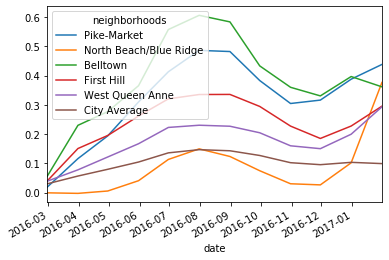

In [10]:
plot_neghborhood_price_rates(df_seattle, n_neighborhoods=5, top=True)

Pike-Market, North Beach/Blue Ridge, Belltown, First Hill, West Queen Anne

Question 2: What neighborhoods have had the highest percent decrease in price in Seattle?

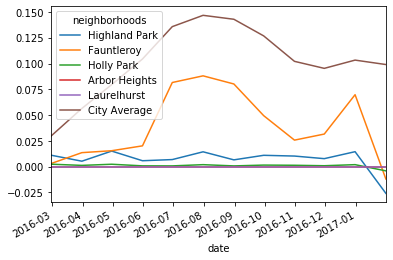

In [11]:
plot_neghborhood_price_rates(df_seattle, n_neighborhoods=5, top=False)

Highland Park, Fauntleroy, Holly Park, Arbor Heights, Laurelhurst

Question 3: What neighborhoods have had the highest percent increase in price in Boston?

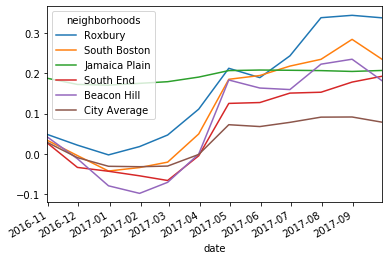

In [12]:
plot_neghborhood_price_rates(df_boston, n_neighborhoods=5, top=True)

Roxbury, South Boston, Jamaica Plain, South End, Beacon Hill

Question 4: What neighborhoods have had the highest percent decrease in price in Boston?

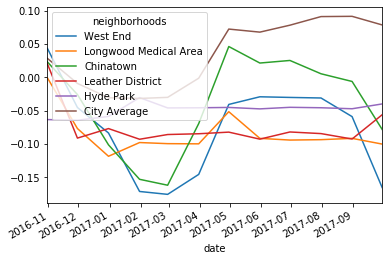

In [13]:
plot_neghborhood_price_rates(df_boston, n_neighborhoods=5, top=False)

West End, Longwood Medical Area, Chinatown, Leather District, Hyde Park

Question 5: Can categorical descriptions of AirBnB listings be used to predict the listing price of an AirBnB in Boston
Is a random forest a good tool to  of an AirBnB listing in Boston 2016?


In [14]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

%matplotlib inline

stop = set(stopwords.words('english'))

df = pd.read_csv(os.path.abspath("/Users/jbeaudi/Udacity/boston/listings.csv"))

Select columns that may have some relevance. 

In [15]:
selected_columns = ['house_rules',
                    'host_since', 
                    'host_response_rate',
                    'host_acceptance_rate',
                    'host_listings_count',
                    'zipcode',
                    'property_type',
                    'room_type',
                    'accommodates',
                    'bathrooms',
                    'bedrooms',
                    'beds',
                    'bed_type',
                    'amenities',
                    'square_feet',
                    'price',
                    'weekly_price',
                    'monthly_price',
                    'security_deposit',
                    'cleaning_fee',
                    'guests_included',
                    'extra_people',
                    'minimum_nights',
                    'maximum_nights', 
                    'availability_30',
                    'availability_60',
                    'availability_90',
                    'availability_365',
                    'number_of_reviews',
                    'last_review',
                    'review_scores_rating',
                    'review_scores_accuracy',
                    'review_scores_cleanliness',
                    'review_scores_checkin',
                    'review_scores_communication',
                    'review_scores_location',
                    'review_scores_value', 
                    'cancellation_policy',
                    'calculated_host_listings_count',
                    'reviews_per_month']
df = df[selected_columns]

Remove columns with 75% of values missing

In [16]:
mostly_missing = df.isnull().sum() * 100 / len(df) > 75
df = df.iloc[:, ~mostly_missing.values]

Clean zip code data. It appears that one of the values is the combination of 2 zipcodes

In [17]:
df["zipcode"] = df["zipcode"].apply(lambda val: str(val).split("-")[0])
print(df["zipcode"].value_counts())
df = df[df["zipcode"] != "02108 02111"]

02116          388
02130          331
02118          247
02215          236
02134          233
02114          231
02127          180
02135          172
02115          169
02128          146
02125          129
02120          115
02113          101
02119          100
02111           99
02129           90
02124           80
02210           75
02108           72
02131           65
02109           51
02122           44
nan             38
02132           37
02121           29
02136           29
02126           24
02110           13
02145           12
02446            8
02143            7
02139            6
02138            6
02445            5
02467            5
02141            3
02163            3
02108 02111      1
02186            1
02169            1
02142            1
02218            1
02472            1
Name: zipcode, dtype: int64


Create dummy variables for all amenities

In [18]:
def process_amenities(cell_val, stop=stop):
    cell_val = cell_val.replace("{", "").replace("}", "").replace("\"", "").replace("(s)", "").replace(":", "").lower().replace("/", "").replace(" ", "_").split(",")
    # remove stop words
    cell_val = set(cell_val) - stop
    # remove amenities that begin with en.hosting_amenity_
    cell_val = tuple(filter(lambda amenity: 0 if amenity.startswith("translation_missing_en.hosting_amenity_") else 1, cell_val))
    return cell_val


df = pd.concat([df.drop("amenities", axis=1),
                pd.get_dummies(df["amenities"].apply(process_amenities).str.join('|').str.get_dummies().add_prefix('amenities_'),
                               prefix="amenities",
                               prefix_sep='_',
                               drop_first=True,
                               dummy_na=False)],
               axis=1)

convert host since variable to integer

In [19]:
col = "host_since"
df[col] = pd.to_datetime(df[col])
timescale_end = max(df[col]) + datetime.timedelta(days=1)
df[col] = df[col].apply(lambda val: timescale_end - val).dt.days
df[col].rename("relative_days_host")

0        511
1       1553
2       2676
3       1235
4        850
        ... 
3580     769
3581     433
3582     967
3583     103
3584     384
Name: relative_days_host, Length: 3584, dtype: int64

create dummy variables for all categorical variables

In [20]:
categorical_vars = ["zipcode",
                    "cancellation_policy",
                    "property_type",
                    "room_type",
                    "bed_type"]

for categorical_var in categorical_vars:
    df = pd.concat([df.drop(categorical_var, axis=1),
                    pd.get_dummies(df[categorical_var],
                                   prefix=categorical_var,
                                   prefix_sep='_',
                                   drop_first=True,
                                   dummy_na=False)],
                   axis=1)

convert percent to float

In [21]:
percent_str_vars = ["host_response_rate",
                    "host_acceptance_rate"]
percent_str_to_float = lambda percent: float(percent.replace("%", "")) if isinstance(percent, str) else percent
for percent_str_var in percent_str_vars:
    df[percent_str_var] = df[percent_str_var].apply(percent_str_to_float)

Record whether a house has rules or not

In [22]:
has_value_vars = ["house_rules",
                  "last_review"]
has_value = lambda rule: 1 if isinstance(rule, str) else 0
for has_value_var in has_value_vars:
    df[has_value_var] = df[has_value_var].apply(has_value)

Convert USD string into float value

In [23]:
usd_str_vars = ["price",
                "security_deposit",
                "extra_people",
                "cleaning_fee"]
usd_str_to_float = lambda usd: np.float32(usd.replace("$", "").replace(",", "")) if isinstance(usd, str) else usd
for usd_str_var in usd_str_vars:
    df[usd_str_var] = df[usd_str_var].apply(usd_str_to_float)

Fill in all missing values with the mean

In [24]:
df = df.fillna(df.mean())

Drop rows whose price exceeds three standard deviations from the mean

In [25]:
# drop price outliers
df = df[df["price"] <= df["price"].mean() + 3*df["price"].std()]

Split data into training and test sets

In [26]:
# take log of y because distribution has a heavy left tail
y = np.log(df["price"])
# scale y between 1 and 0
y -= y.min()
y /= y.max()
# Using Skicit-learn to split data into training and testing sets
y = np.array(y)# Remove the labels from the features
# axis 1 refers to the columns
X = df.drop('price', axis = 1)# Saving feature names for later use
X = np.array(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.35, random_state = 42)

Create a random forest and calculate its rmse

In [27]:
def eval_rf(n_estimators, X_train, X_test, y_train, y_test):
    # Import the model we are using
    rf = RandomForestRegressor(n_estimators=n_estimators, random_state=42)# Train the model on training data
    rf.fit(X_train, y_train);

    # Use the forest's predict method on the test data
    predictions = rf.predict(X_test)# Calculate the absolute errors
    sq_errors = list(map(lambda val: val*val, predictions - y_test))
    rmse = (sum(sq_errors) / len(sq_errors))**(1/2)
    return rmse

create multiple random forest models with different amounts of trees

In [28]:
estimators = list(range(1, 19)) + list(range(20, 100, 10))
rmse = [eval_rf(n_estimators, X_train, X_test, y_train, y_test) for n_estimators in estimators]

Compare number of trees to rmse

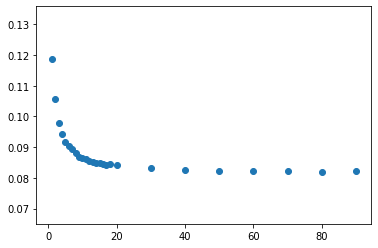

In [29]:
plt.scatter(estimators, rmse)
plt.show()

In [30]:
min(rmse)

0.08203284443674697

Beause the prices were scaled between 1 and 0, the observed MSRE is pretty low at around 0.082, which starts arounf random forest with at least 30 trees